In [ ]:
import numpy as np
from scipy import stats
from scipy.stats import poisson
import matplotlib.pyplot as plt
from scipy.special import factorial
from numpy.random import normal
from scipy.linalg import norm
from itertools import product

# Taller 1 
Nicolás Betancourt



Optimización estocástica

## Introducción al problema

Se quiere diseñar un proceso de abastecimiento mensual de unidades de determinado bien, de forma que se maximicen las ganancias después de costos operativos. Para esto estableceremos la siguiente notación: 

Al inicio de cada mes $t\in\{1,2,\cdots\}$ se tiene un nivel de inventario aleatoreo 
$$S_t\in S:=\{0,\cdots,M\}$$
ante el cual debemos tomar la decisión de cuántas unidades  $$a_t\in\mathcal{A}(S_t):= \{0,1,\cdots,M-S_t\}$$ de inventario adquirir.

Como queremos satisfacer la demanda $D_t$ de este bien en el mes $t$, podemos asumir que las unidades en inventario al siguiente mes están dadas por 
$$S_{t+1}=\max\{0,S_t+a_t-D_t\}.$$
Para hablar de ganancias y costos operativos, sean $K$ los costos fijos y $c(u)$ los costos variables de adquirir $u$ unidades del bien. De esta forma, el valor del costo de ordenar $u$ unidades de producto va a estar dado por 
$$O(u):=\begin{cases}K+c(u)&u>0\\0&u=0\end{cases}.$$
Vamos a asumir que los únicos costos además de los de adquisición, son los de bodegaje (costo de mantener $u$ unidades de inventario en bodega) dados por $h(u)$. Finalmente, las ganancias por vender $j$ unidades son $f(j)$ si $j\leq S_t+a_t$ y $f\left(S_t+a_t\right) $ de lo contrario.


Así pues las ganacias después de costos operativos van a estar dadas por 
$$r_t(s,a,S_{t+1})=f(s+a-S_{t+1})-O(s)-h(s+a)$$
que implica que 
\begin{align}r_t(s,a):= &E[r_t(s,a,S_{t+1})]=E[f(s+a-S_{t+1})]-O(a)-h(s+a)\\
                                            \quad \\
                &=\sum_{k=0}^{\infty}f(k)\Pr(s+a+S_{t+1}=k)-O(a)-h(s+a)\\
                \quad \\
                &=f(s+a)\Pr\left(S_{t+1}=0\right)+\sum_{j<s+a}f(j)\Pr\left(D_t=j\right)-O(a)-h(s+a)\\
                &=f(s+a)\sum_{j\geq s+a}\Pr\left(D_t=j\right)+\sum_{j<s+a}f(j)\Pr\left(D_t=j\right)-O(a)-h(s+a)\\
                &=f(s+a)\Pr(D_t\geq s+a) + \sum_{j<s+a}f(j)\Pr\left(D_t=j\right)-O(a)-h(s+a) \\
                &=\underbrace{f(s+a)(1-\Pr(D_t\leq s+a-1))+\sum_{j<s+a}f(j)\Pr\left(D_t=j\right)}_{F(s+a):=} -O(a)-h(s+a)
                \end{align}

Con lo anterior ya tendríamos espacio de estados, acciones y recompensas. Para tener un proceso de decisión de Markov restaría tener solo las probabilidades de transición que van a estar dadas por
$$\Pr(j|s,a):=\begin{cases}0 & j>s+a\\  \Pr\left(D_t=s+a-j\right) &s+a\geq j>0 \\  1-\Pr\left(D_t\leq s+a-1\right) & j=0 \end{cases}$$

## Código y resultados numéricos

### Funciones básicas y variables globales que se necesitan para todos los puntos

In [ ]:
punto='Primer punto' #Variable que creamos para no tener que cambiar la función c(u) para los distintos puntos
K=2
lmbda=0.9
M=100
#Ganancias
def f(s):
    return 10*s
#Costo variable por orden
def c(s):
    if punto in ['Primer punto','Tercer punto']:
        return 2*s
    if punto=='Segundo punto':
        return -0.01*s**2+3*s
#Costo de bodegaje
def h(s):
    return s
#Costo de orden
def O(a):
    v=K+c(a)
    v[a==0]=0
    return v
#Recompensas
#Para hacer más fácil la escritura de puntos a continuación
#Voy a establecer que cuando a no es un estado admisible
# i.e. s+a>M, entonces r(s,a)=-infty
def r(s):
  a=np.arange(M+1)
  matriz=np.tril(np.array([np.arange(M+1)]*(M+1)), k=s-1)
  F=f(s+a)*(1-poisson.cdf(s+a-1,10))+np.matmul(f(matriz), poisson.pmf(a,10))   
  recompensa=F-O(a)-h(s+a)
  recompensa[M-s+1:]=-np.inf
  return recompensa
#Probabilidades de transición
def p(s):
  p_s=np.tril(np.array([ poisson.pmf(s+a-np.arange(M+1),10) for a in range(M+1)]),k=s)
  p_s[:,0]=1-poisson.cdf(s+np.arange(M+1)-1,10)
  p_s[np.arange(M-s+1,M+1),:]=0
  return p_s
  

### Primer punto

Suponga que $\lambda=0.9$, $M=100$ y que $D_t\sim \operatorname{Poisson}(10)$, $h(s)=s$, $K=2$, $f(s)=10s$ y $c(s)=2s$
Encontrar la función de valor y la estrategia óptima usando 

#### Iteración por valor

Antes vamos a hacer una justificación matemática del codigo a continuación. Necesitamos encontrar un punto fijo $v$ de 
$$ \mathcal{L}v(s):=\max_{a}\{r(s,a)+\lambda\sum_{j=0}^M p(j|s,a)v(j)\} $$

Defina

$$ P_{sa}:=\begin{pmatrix} p(0|s,a)\\ p(1|s,a) \\ \vdots \\ p(M|s,a) \end{pmatrix} \quad \text{y} \quad r_s:=\begin{pmatrix} r(s,0)\\ r(s,1) \\ \vdots \\ r(s,M) \end{pmatrix}$$

Si $P_s\in \mathbb{R}^{(M+1)\times (M+1)}$ es la matriz cuya fila $a$ es $ P_{sa}$ entonces 
$$ \mathcal{L}v(s)= \max \left( r(s)+\lambda P_s v \right) $$
donde el máximo es tomado componente a componente. 


Finalmente, si defino $w_s:=r(s)+\lambda P_s v$ y para una matriz $X$ defino $\max X \in \mathbb{R}^{(M+1)\times 1} $ como el máximo en cada fila, obtengo que 


$$ $$


$$ \mathcal{L}v=\max \begin{pmatrix} w_0^T \\ \hline w_1^T \\ \vdots \\ \hline w_M^T  \end{pmatrix} $$ 


Rercuerde que todo lo anterior tiene sentido porque establecimos

$$p(j|s,a)=0 \quad \text{y} \quad r(s,a)=-\infty$$ 

para todo $a\notin \mathcal{A}(s)$ i.e. siempre que $ s+a>M$. 


In [ ]:
# Definimos la contracción a la cual le vamos a encontrar un casi punto fijo
#L(v)=v
# Acá v es un vector en R^M
def L2(v):
  v=v.reshape((M+1,1))
  #Creamos una lista para almacenar los w_s
  valoresMaximos=[]
  for s in range(M+1):
      r_s=r(s).reshape((M+1,1))
      P_s=p(s)
      valoresMaximos.append(float(max(r_s+lmbda*np.matmul(P_s,v))))

  return np.array(valoresMaximos).reshape((M+1,1))

In [ ]:
    
    
#Elegimos un varEps pequeño
varEps=10**-2
#Se inicializa v0 en 0
v_VI=np.zeros((M+1,1))
#Iteramos hasta satisfacer el criterio de parada
cont=0
vectoresVI=[]
v_VINext=L2(v_VI)
while norm(v_VI-v_VINext,ord=np.inf)>=varEps*(1-lmbda)/(2*lmbda):
  vectoresVI.append(v_VI)
  cont+=1
  v_VI=v_VINext
  v_VINext=L2(v_VI)

    

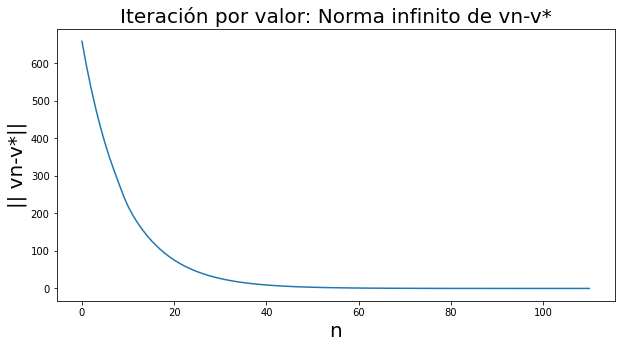

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Iteración por valor: Norma infinito de vn-v*',fontsize=20)
ax.set_xlabel('n',fontsize=20)
ax.set_ylabel('|| vn-v*||',fontsize=20)
#ax.axhline(y=varEps*(1-lmbda)/(2*lmbda), c='red')
#ax.legend(['Criterio de parada'])
plt.plot([norm(v_VI-x,ord=np.inf) for x in vectoresVI])

Utilizando el $v$ óptimo obtenido, conseguimos la regla de decisión $\mu$ óptima  que va a dar lugar a la política estacionaria $\pi=(\mu,\cdots,\mu)$ óptima.

In [ ]:
mu_VI=np.zeros((M+1,1))
for s in range(M+1):
    #Diccionario en donde almacenamos {a: r(s,a)+ lambda sum p(j|s,a)v(j)}
    valores=np.zeros(M+1)
    r_s=r(s)
    for a in range(M-s+1):
        x=lmbda*p(s)[a]
        #np.array([[p(j,s,a)] for j in range(M+1)])
        valor=float(np.matmul(x.T,v_VI))
        valores[a]=valor
    #Obtener la llave (el a) del diccionario donde el valor fue máximo y 
    # almacenarlo en el vector mu2 en la entrada s
    vector=r_s+valores
    mu_VI[s][0]=np.argmax(vector)
    #float(max(valores, key=valores.get))
    

Esta política estacionaria es de la forma
$$\mu(s)=\begin{cases}\Sigma-s & s<\sigma \\ 0 & s\geq \sigma\end{cases}$$
tal como sucedía en el libro. En este caso

In [ ]:
print('Sigma mayúscula es ', float(max(mu_VI)), ' y sigma minúscula es ', max(np.nonzero(mu_VI)[0]))

Sigma mayúscula es  13.0  y sigma minúscula es  10


#### Gauss-Seidel

Antes vamos a hacer una justificación matemática del codigo a continuación. En cada paso necesitamos calcular $v_{n+1}$ con la regla
$$ v_{n+1}(s):=\max_{a}\left\{r(s,a)+\lambda\left[\sum_{j<s} p(j|s,a)v_{n+1}(j)+\sum_{j\geq s} p(j|s,a)v_{n}(j)\right]\right\} $$

Si en lo anterior a  $v_{n+1} $ lo inicializamos en cero y vamos actualizando sus entradas según la regla anterior, en el paso $s-$ésimo vamos a tener que $v_{n+1}(j)=0 $ para todo $j\geq s $, de forma que, utilizando la notación del ejercicio anterior tendríamos

$$ \sum_{j<s} p(j|s,a)v_{n+1}(j) = \langle P_{sa}, v_{n+1} \rangle.$$
 

Sea, por otro lado, $Q_s\in \mathbb{R}^{M\times M}$ la matriz  resultante de reemplazar  las primeras $s-1$ filas de $P_s$ con ceros. Con todo esto tendríamos que 

$$ v_ {n+1}(s)= \max \left( r(s) + \lambda\left(  P_sv_{n+1} + Q_sv_n \right) \right) $$

Y si $w_s:= r(s) + \lambda\left(  P_sv_{n+1} + Q_sv_n \right)$, entonces 

$$ v_{n+1}= \max \begin{pmatrix} w_0^T \\ \hline w_1^T \\ \vdots \\ \hline w_M^T \end{pmatrix}$$





In [ ]:
#Función que reemplaza las primeras n filas de una matriz X por ceros
def Q(X,n):
  Y=X.copy()
  Y[range(n),:]=np.zeros(Y.shape[1])
  return Y
#Función que recibe v_n y escupe v_n+1 como describimos antes
def L_GS(v):
  v=v.reshape((M+1,1))
  #Inicializamos en cero porque lo prometido es deuda
  vn=np.zeros((M+1,1))
  #Creamos una lista para almacenar los w_s
  outPut=[]
  for s in range(M+1):
      r_s=r(s).reshape((M+1,1))
      P_s=p(s)
      Q_s=Q(P_s,s-1)
      w_s=r_s+lmbda*(np.matmul(P_s,vn)+np.matmul(Q_s,v))
      outPut.append(max(w_s))
  
  return np.array(outPut).reshape((M+1,1))




In [ ]:
#Se inicializa v0 en 0
v_GS=np.zeros((M+1,1))
#Iteramos hasta satisfacer el criterio de parada
cont=0
vectoresGS=[]
v_GSNext=L_GS(v_GS)
while norm(v_GS-v_GSNext,ord=np.inf)>=varEps*(1-lmbda)/(2*lmbda):
  vectoresGS.append(v_GS)
  cont+=1
  #if cont%20==0:
  #    print(cont)
  v_GS=v_GSNext
  v_GSNext=L_GS(v_GS)

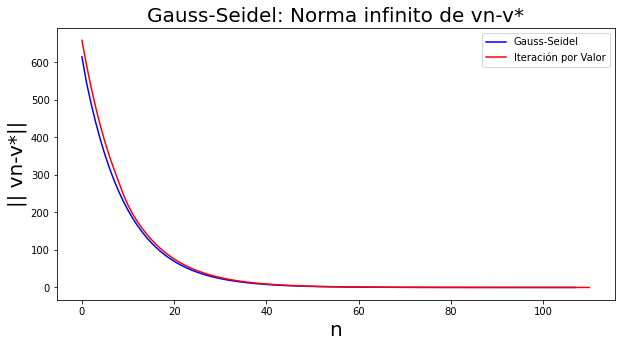

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Gauss-Seidel: Norma infinito de vn-v*',fontsize=20)
ax.set_xlabel('n',fontsize=20)
ax.set_ylabel('|| vn-v*||',fontsize=20)
#ax.axhline(y=varEps*(1-lmbda)/(2*lmbda), c='red')

ax.plot([norm(v_GS-x,ord=np.inf) for x in vectoresGS],c='blue')
ax.plot([norm(v_VI-x,ord=np.inf) for x in vectoresVI],c='red')
ax.legend(['Gauss-Seidel','Iteración por Valor'])


Utilizando el $v$ óptimo obtenido podemos calcular la política estacionaria óptima como sigue

In [ ]:
mu_GS=np.zeros((M+1,1))
for s in range(M+1):
    #Diccionario en donde almacenamos {a: r(s,a)+ lambda sum p(j|s,a)v(j)}
    valores=np.zeros(M+1)
    r_s=r(s)
    for a in range(M-s+1):
        x=lmbda*p(s)[a]
        #np.array([[p(j,s,a)] for j in range(M+1)])
        valor=float(np.matmul(x.T,v_GSNext))
        valores[a]=valor
    #Obtener la llave (el a) del diccionario donde el valor fue máximo y 
    # almacenarlo en el vector mu2 en la entrada s
    vector=r_s+valores
    mu_GS[s][0]=np.argmax(vector)
    #float(max(valores, key=valores.get))
    

Esta política estacionaria es de la forma
$$\mu(s)=\begin{cases}\Sigma-s & s<\sigma \\ 0 & s\geq \sigma\end{cases}$$
tal como sucedía en el libro. En este caso

In [ ]:
print('Sigma mayúscula es ', max(mu_GS), ' y sigma minúscula es ', max(np.nonzero(mu_GS)[0]))


Sigma mayúscula es  [12.]  y sigma minúscula es  10


#### Jacobi

El spliting dado significa que $v^{n+1}$ es solución al sistema 
$$ v^{n+1}=r_a+\lambda \operatorname{Diag}(P_a)v^{n+1}+\lambda P_a^Av^n$$
donde $P_a$ está dada por $(P_a)_{s,j}=\Pr(j|s,a)$, $\operatorname{Diag}$ representa la diagonal y elevar a la $A$ significa todo lo de $A$fuera de la diagonal. Con lo anterior, las iteraciones serían

$$ v^{n+1}(s)=\max_a\left\{\frac{1}{1-\lambda\Pr(s|s,a)}\left[r(s,a)+\lambda\sum_{j\neq s}\Pr(j|s,a)v^n(j)\right]\right\}$$





In [ ]:
def L_J(v):
  v=v.reshape((M+1,1))
  outPut=[]
  for s in range(M+1):
    X=p(s)
    Y=X.copy()
    proba_ss=Y[:,s]
    escalar=1/(1-lmbda*proba_ss)
    escalar=escalar.reshape((M+1,1))
    X[:,s]=0
    r_s=r(s).reshape((M+1,1))
    valor=float(np.max( escalar*(r_s+lmbda*np.matmul(X,v))))
    if valor==np.nan or valor==np.inf:
      print(s,valor)
    outPut.append(valor)
  return np.array(outPut).reshape((M+1,1))



In [ ]:
#Elegimos un varEps pequeño
varEps=10**-2
#Se inicializa v0 en 0
v_J=np.zeros((M+1,1))
#Iteramos hasta satisfacer el criterio de parada
cont=0
vectoresJ=[]
v_JNext=L_J(v_J)
while norm(v_J-v_JNext,ord=np.inf)>=varEps*(1-lmbda)/(2*lmbda):
  vectoresJ.append(v_J)
  cont+=1
  v_J=v_JNext
  v_JNext=L_J(v_J)

Utilizando el $v$ óptimo obtenido podemos calcular la política estacionaria óptima como sigue

In [ ]:
mu_J=np.zeros((M+1,1))
for s in range(M+1):
    #Diccionario en donde almacenamos {a: r(s,a)+ lambda sum p(j|s,a)v(j)}
    valores=np.zeros(M+1)
    r_s=r(s)
    for a in range(M-s+1):
        x=lmbda*p(s)[a]
        #np.array([[p(j,s,a)] for j in range(M+1)])
        valor=float(np.matmul(x.T,v_JNext))
        valores[a]=valor
    #Obtener la llave (el a) del diccionario donde el valor fue máximo y 
    # almacenarlo en el vector mu2 en la entrada s
    vector=r_s+valores
    mu_J[s][0]=np.argmax(vector)
    #float(max(valores, key=valores.get))
    

Esta política estacionaria es de la forma
$$\mu(s)=\begin{cases}\Sigma-s & s<\sigma \\ 0 & s\geq \sigma\end{cases}$$
tal como sucedía en el libro. En este caso

In [ ]:
print('Sigma mayúscula es ', max(mu_J), ' y sigma minúscula es ', max(np.nonzero(mu_J)[0]))


Sigma mayúscula es  [13.]  y sigma minúscula es  10


#### Gráfica similar a 6.3.1

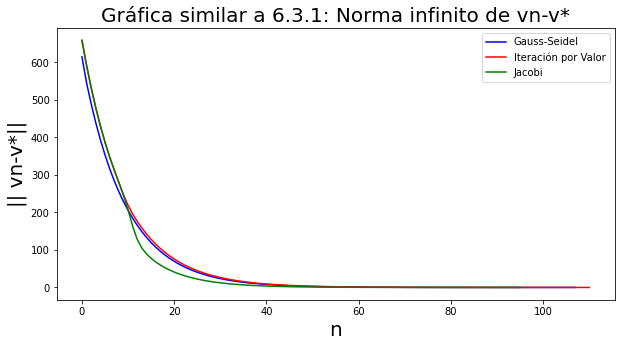

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Gráfica similar a 6.3.1: Norma infinito de vn-v*',fontsize=20)
ax.set_xlabel('n',fontsize=20)
ax.set_ylabel('|| vn-v*||',fontsize=20)
ax.plot([norm(v_GS-x,ord=np.inf) for x in vectoresGS],c='blue')
ax.plot([norm(v_VI-x,ord=np.inf) for x in vectoresVI],c='red')
ax.plot([norm(v_J-x,ord=np.inf) for x in vectoresJ],c='green')
ax.legend(['Gauss-Seidel','Iteración por Valor', 'Jacobi'])
plt.show()

### Segundo punto

Suponga que ahora $c(s)=-0.01s^2+3s$ y encuentre la función de valor y la estrategia óptimas usando el método que quiera. 

In [ ]:
#Cambiamos la variable global punto para que el output de la funcióón c(s)
#sea el solicitado
punto='Segundo punto'
#Se inicializa v0 en 0
v_GS2=np.zeros((M+1,1))
#Iteramos hasta satisfacer el criterio de parada
cont=0
#vectoresGS2=[]
#Utilizaremos Gauss Seidel porque ha sido bueno con nosotros
v_GS2Next=L_GS(v_GS2)
while norm(v_GS2-v_GS2Next,ord=np.inf)>=varEps*(1-lmbda)/(2*lmbda):
  v_GS2=v_GS2Next
  v_GS2Next=L_GS(v_GS2)

In [ ]:
mu_GS2=np.zeros((M+1,1))
for s in range(M+1):
    #Diccionario en donde almacenamos {a: r(s,a)+ lambda sum p(j|s,a)v(j)}
    valores=np.zeros(M+1)
    r_s=r(s)
    for a in range(M-s+1):
        x=lmbda*p(s)[a]
        #np.array([[p(j,s,a)] for j in range(M+1)])
        valor=float(np.matmul(x.T,v_GS2Next))
        valores[a]=valor
    #Obtener la llave (el a) del diccionario donde el valor fue máximo y 
    # almacenarlo en el vector mu2 en la entrada s
    vector=r_s+valores
    mu_GS2[s][0]=np.argmax(vector)
    #float(max(valores, key=valores.get))

Esta política estacionaria es de la forma
$$\mu(s)=\begin{cases}\Sigma-s & s<\sigma \\ 0 & s\geq \sigma\end{cases}$$
tal como sucedía en el libro. En este caso

In [ ]:
print('Sigma mayúscula es ', max(mu_GS2), ' y sigma minúscula es ', max(np.nonzero(mu_GS2)[0]))


Sigma mayúscula es  [12.]  y sigma minúscula es  9


Como $\frac{s}{100}\leq 1$ para todo $s\in S$, entonces $\frac{s^2}{100}<s$ de lo que se concluye que $ 3s-0.01s^2 \geq 3s-s=2s$ para todo $s$. Esto quiere decir que en este escenario los costos operativos aumentan y por lo tanto el cabe esperar que el nivel mínimo de inventario sea se menor. Esto es preciamente lo que observamos en lo anterior.

### Tercer punto

In [ ]:
punto='Tercer punto'
#Se itera para lambda=0.95,0.85, 0.8, 0.75,..., 0.05
#Se almacenan las políticas óptimas y los v_lmbda 
# en un diccionario con llave lmbda
diccionario_mu={}
diccionario_v={} 
for lmbda in np.arange(start=0.05,stop=0.95, step=0.05):
  v_3=np.zeros((M+1,1))
  #Iteramos con GS hasta satisfacer el criterio de parada
  cont=0
  v_3Next=L_J(v_3)  
  while norm(v_3-v_3Next,ord=np.inf)>=varEps*(1-lmbda)/(2*lmbda):
    v_3=v_3Next
    v_3Next=L_J(v_3)
  diccionario_v[lmbda]=v_3
  
  

In [ ]:
for lmbda in diccionario_v.keys():
  mu_3=np.zeros((M+1,1))
  v_3Next=diccionario_v[lmbda]
  for s in range(M+1):
    #Diccionario en donde almacenamos {a: r(s,a)+ lambda sum p(j|s,a)v(j)}
    valores=np.zeros(M+1)
    r_s=r(s)
    for a in range(M-s+1):
        x=lmbda*p(s)[a]
        #np.array([[p(j,s,a)] for j in range(M+1)])
        valor=float(np.matmul(x.T,v_3Next))
        valores[a]=valor
    #Obtener la llave (el a) del diccionario donde el valor fue máximo y 
    # almacenarlo en el vector mu2 en la entrada s
    vector=r_s+valores
    mu_3[s][0]=np.argmax(vector)
    #float(max(valores, key=valores.get))
  diccionario_mu[lmbda]=mu_3

Vamos a comparar las políticas resultantes mirando los niveles máximo y mínimo de inventario $\Sigma(\lambda)$ y $\sigma(\lambda)$ para cada $\lambda$

In [ ]:
SigmaGrande=[]
sigmaChiquito=[]
for lmbda in diccionario_mu.keys():
  mu_lmbda=diccionario_mu[lmbda]
  SigmaGrande.append(max(mu_lmbda))
  sigmaChiquito.append(max(np.nonzero(mu_lmbda)[0]))
  

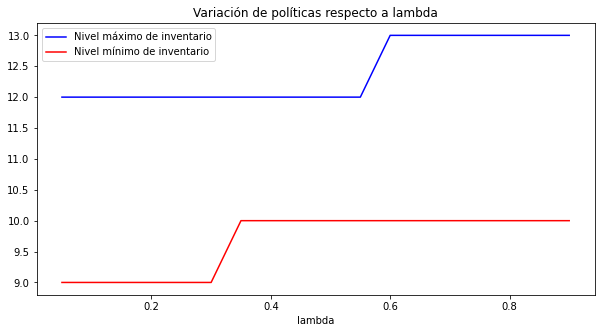

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
#ax.set_title('Gauss-Seidel: Norma infinito de vn-v*',fontsize=20)
#ax.set_xlabel('n',fontsize=20)
#ax.set_ylabel('|| vn-v*||',fontsize=20)
#ax.axhline(y=varEps*(1-lmbda)/(2*lmbda), c='red')

ax.plot(np.arange(start=0.05,stop=0.95, step=0.05), SigmaGrande,c='blue')
ax.plot(np.arange(start=0.05,stop=0.95, step=0.05), sigmaChiquito,c='red')
ax.set_xlabel('lambda')
ax.set_title('Variación de políticas respecto a lambda')
ax.legend(['Nivel máximo de inventario','Nivel mínimo de inventario'])

Cuando $\lambda \to 1$ sabemos que $V_\lambda$ y $\mu_{V_{\lambda}}$ tienen a los verdaderos valores y políticas óptimas. 
Hemos además comprobado numéricamente  que una política estacionaria $\mu$ que soluciona nuestro problema tiene la forma

$$\mu(s)=\begin{cases}\Sigma-s & s<\sigma \\ 0 & s\geq \sigma\end{cases}$$
tal como sucedía en el libro. En este caso

De esta forma, al tomar valores de $\lambda$ cercanos a 1 vamos a obtener valores de $\Sigma(\lambda)$ y $\sigma(\lambda)$ cada vez más fieles a los niveles de inventario mínimo y máximo óptimos. Basados en la gráfica anterior estos niveles serían




In [ ]:
print('Sigma grande óptimo=', SigmaGrande[-1])
print('Sigma chiquito óptimo=', sigmaChiquito[-1])


Sigma grande óptimo= [13.]
Sigma chiquito óptimo= 10


# Conclusiones

Además de lo que ya se ha concluido puntualmente en los ejercicios se me ocurren las siguientes conclusiones


1. El $\sigma$ óptimo siempre era cercano o mayor a la media de la demanda (10 en este caso de $\operatorname{Poisson}(10)$), yo creería que de forma más general podríamos decir que la política óptima va a involucrar tener al menos suficiente inventario para satisfacer la demanda promedio.
2. Cuando cambiamos la función de costo unitario $c(u)$ por una más costosa, el cambio no fue tan dramático, esto puede deberse a que la diferencia entre una función y la otra era pequeña o a que el modelo no es tan sensible a cambios en este parámetro.
3. Para valores de $\lambda<1 $ pequeños el modelo es muy desacertado pues  $\sigma(\lambda) $  son menores a la media de la demanda.  Después de cierto $\lambda$ no tan grande ($\lambda=0.6$ como se puede ver en la gráfica del último punto)la solución se estabiliza  y es igual a la solución con $\lambda$ muy cercano a 1.
4.  Si bien Jacobi y Gauss Seidel requirieron menos iteraciones como se puede ver en la última gráfica del primer punto, el método que menos segundos tomó (200) fue iteración por valor. Esto me hace pensar que las iteraciones son menos pero más costosas en los otros dos métodos que se demoraron más de 500 segundos.
5. Para correr la tarea utilicé $M$ más pequeños que 100, y a partir de 20 las soluciones todas eran las mismas. Eso quiere decir que al final el modelo no es sensible a ese parámetro sino más bien a la demanda. De hecho, yo conjeturaría que para todo $M$ mayor a la media de la demanda, la solución es la misma.
6. He hablado mucho de $\sigma$. Yo creo que los costos y todo eso son los que determinan que inventario máximo $\Sigma$ tengo, como se pudo ver en el segundo punto. Esto tiene sentido pues si no hubiera costos de bodegaje ni adquisición, pues tendría un inventario arbitrariamente grande para satisfacer cualquier eventual demanda. 

